# Cryptocurrency Time Series Forecasting Using LSTM & GRU

# Intruduction of the LSTM model

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (e.g. images), but also entire sequences of data (such as speech or video inputs).

LSTM models are able to store information over a period of time. In order words, they have a memory capacity. Remember that LSTM stands for Long Short-Term Memory Model.

This characteristic is extremely useful when we deal with Time-Series or Sequential Data. When using an LSTM model we are free and able to decide what information will be stored and what discarded. We do that using the “gates”. The deep understanding of the LSTM is outside the scope of this post but if you are interested in learning more, have a look at the references at the end of this post.

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

### Import Dataset & Preprocessing


In [2]:
bitcoindf = pd.read_csv('../data/Bitcoin/BTC-USD-NEW.csv')
bitcoindf = bitcoindf.sort_values('date')
bitcoindf = bitcoindf[bitcoindf.columns[1:]]
bitcoindf.head()

,date,open,high,low,close,adj_close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


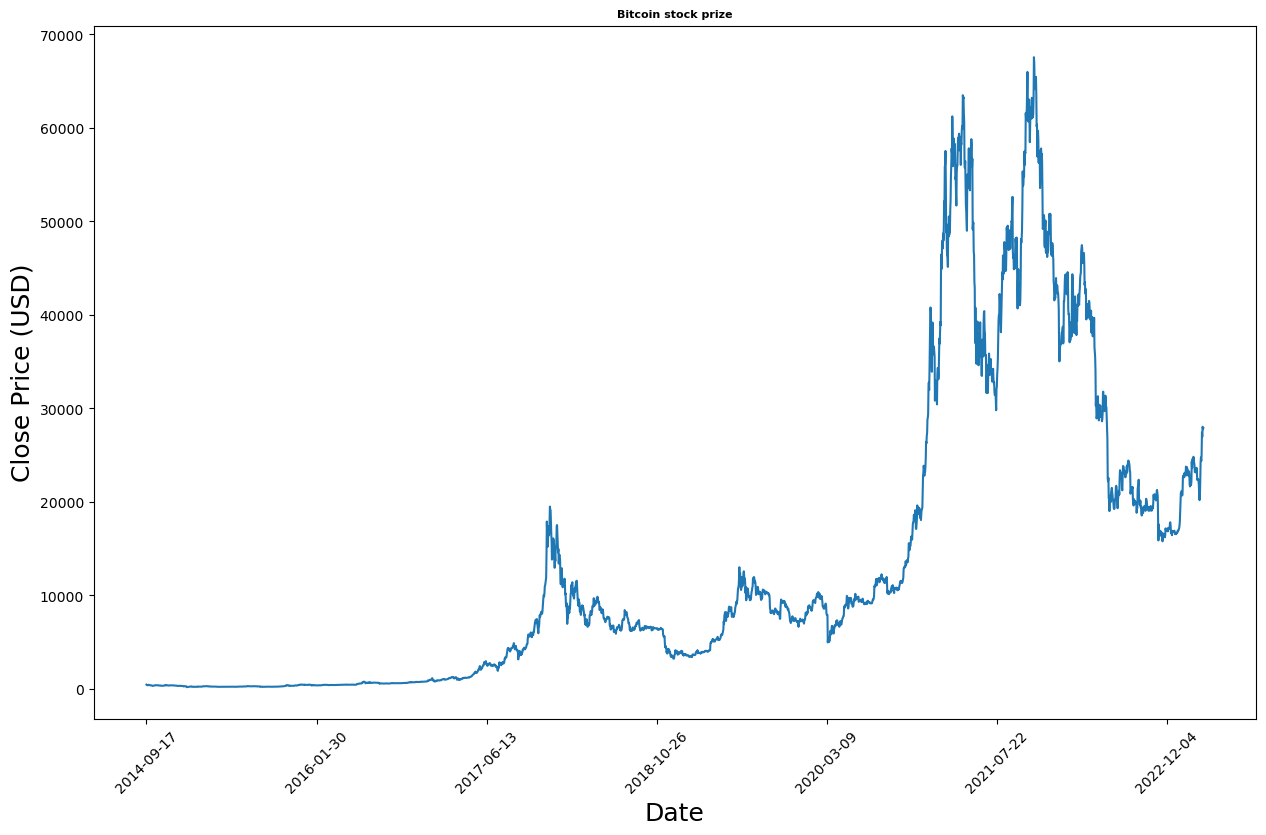

In [3]:
plt.figure(figsize = (15, 9))
plt.plot(bitcoindf[['close']])
plt.xticks(range(0, bitcoindf.shape[0], 500), bitcoindf['date'].loc[::500], rotation = 45)
plt.title('Bitcoin stock prize', fontsize = 8, fontweight = 'bold')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price (USD)', fontsize = 18)  
plt.show()

### Normalize Data

In [4]:
price = bitcoindf[['close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3108 entries, 0 to 3107
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3108 non-null   float64
dtypes: float64(1)
memory usage: 48.6 KB


In [5]:
scaler = MinMaxScaler(feature_range = (-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))

/var/folders/g9/s15kjggj0bb9t_61f58dny800000gn/T/ipykernel_30159/2850328666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))


In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[: train_set_size, :-1, :]
    y_train = data[: train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


x_train.shape =  (2470, 19, 1)
y_train.shape =  (2470, 1)
x_test.shape =  (618, 19, 1)
y_test.shape =  (618, 1)


In [7]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

### LSTM

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)

In [11]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6126973032951355
Epoch  1 MSE:  0.42915019392967224
Epoch  2 MSE:  0.24500030279159546
Epoch  3 MSE:  0.08170756697654724
Epoch  4 MSE:  0.44214609265327454
Epoch  5 MSE:  0.15407656133174896
Epoch  6 MSE:  0.07960957288742065
Epoch  7 MSE:  0.12146790325641632
Epoch  8 MSE:  0.15753395855426788
Epoch  9 MSE:  0.17221978306770325
Epoch  10 MSE:  0.17004160583019257
Epoch  11 MSE:  0.15656591951847076
Epoch  12 MSE:  0.13644909858703613
Epoch  13 MSE:  0.11375288665294647
Epoch  14 MSE:  0.09221626073122025
Epoch  15 MSE:  0.07505214214324951
Epoch  16 MSE:  0.06414283812046051
Epoch  17 MSE:  0.05887597054243088
Epoch  18 MSE:  0.05581199377775192
Epoch  19 MSE:  0.05115620791912079
Epoch  20 MSE:  0.04398057237267494
Epoch  21 MSE:  0.03420542925596237
Epoch  22 MSE:  0.027142776176333427
Epoch  23 MSE:  0.022492844611406326
Epoch  24 MSE:  0.01789293996989727
Epoch  25 MSE:  0.015529011376202106
Epoch  26 MSE:  0.017043018713593483
Epoch  27 MSE:  0.02400244958698749

In [12]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

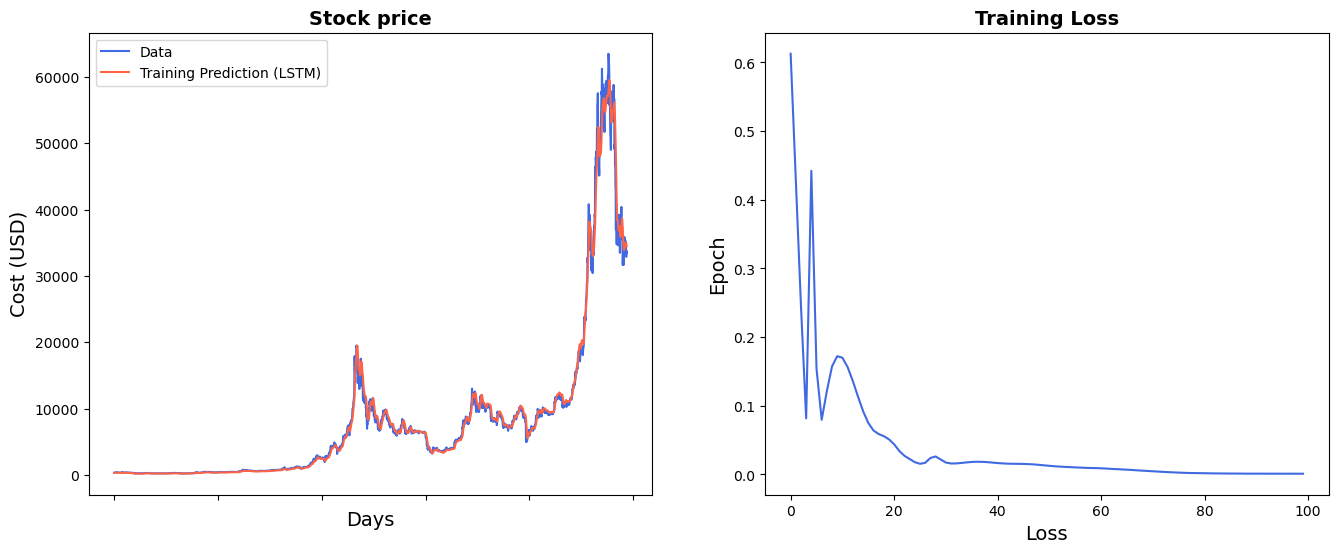

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label = 'Data', color = 'royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label = 'Training Prediction (LSTM)', color = 'tomato')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data = hist, color = 'royalblue')
ax.set_title('Training Loss', size = 14, fontweight = 'bold')
ax.set_xlabel('Loss', size = 14)
ax.set_ylabel('Epoch', size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

In [14]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1118.40 RMSE
Test Score: 42.37 RMSE


In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price['close'].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
predictions = np.append(predictions, original, axis = 1)
result = pd.DataFrame(predictions)

In [16]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[0], mode = 'lines', name = 'Train prediction')))
fig.add_trace(go.Scatter(x = result.index, y = result[1], mode = 'lines', name = 'Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[2], mode = 'lines', name = 'Actual Value')))
fig.update_layout(xaxis = dict(showline = True, showgrid = True, showticklabels = False, linecolor = 'white', linewidth = 2), yaxis = dict(title_text = 'Close (USD)', titlefont = dict(family = 'Rockwell', size = 12, color = 'white'), showline = True, showgrid = True, showticklabels = True, linecolor = 'white', linewidth = 2, ticks = 'outside', tickfont = dict(family = 'Rockwell', size = 12, color = 'white',),), showlegend = True, template = 'plotly_dark')

annotations = []
annotations.append(dict(xref = 'paper', yref = 'paper', x = 0.0, y = 1.05, xanchor = 'left', yanchor = 'bottom', text = 'Results (LSTM)', font = dict(family = 'Rockwell', size = 26, color = 'white'), showarrow = False))

fig.update_layout(annotations = annotations)

fig.show()

### GRU

In [17]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [18]:
model = GRU(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)


In [19]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.8184217214584351
Epoch  1 MSE:  0.2846358120441437
Epoch  2 MSE:  0.08693624287843704
Epoch  3 MSE:  0.18822167813777924
Epoch  4 MSE:  0.1494576334953308
Epoch  5 MSE:  0.07656984031200409
Epoch  6 MSE:  0.0659845620393753
Epoch  7 MSE:  0.08769886195659637
Epoch  8 MSE:  0.0999923050403595
Epoch  9 MSE:  0.08909653127193451
Epoch  10 MSE:  0.06190858781337738
Epoch  11 MSE:  0.03424866870045662
Epoch  12 MSE:  0.023775583133101463
Epoch  13 MSE:  0.03569463640451431
Epoch  14 MSE:  0.0448136106133461
Epoch  15 MSE:  0.03066970594227314
Epoch  16 MSE:  0.009500355459749699
Epoch  17 MSE:  0.002467151964083314
Epoch  18 MSE:  0.010785665363073349
Epoch  19 MSE:  0.020730337128043175
Epoch  20 MSE:  0.020765794441103935
Epoch  21 MSE:  0.012438496574759483
Epoch  22 MSE:  0.005496680270880461
Epoch  23 MSE:  0.00562502583488822
Epoch  24 MSE:  0.008937880396842957
Epoch  25 MSE:  0.009117510169744492
Epoch  26 MSE:  0.005820277612656355
Epoch  27 MSE:  0.002951983362436

In [20]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

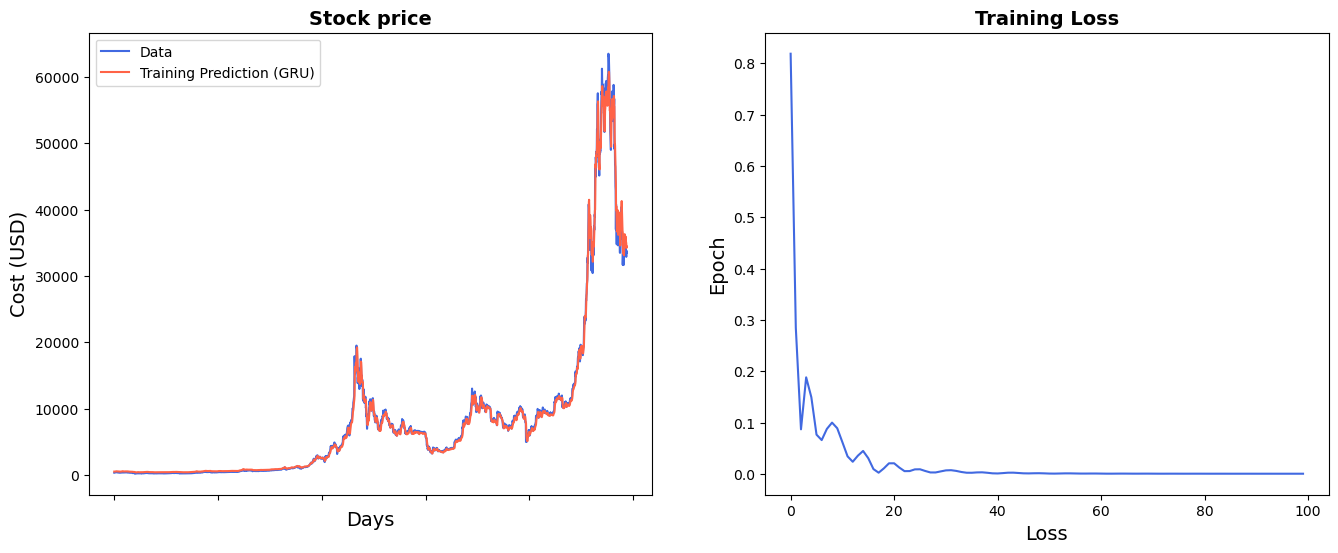

In [21]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label = 'Data', color = 'royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label = 'Training Prediction (GRU)', color = 'tomato')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data = hist, color = 'royalblue')
ax.set_title('Training Loss', size = 14, fontweight = 'bold')
ax.set_xlabel('Loss', size = 14)
ax.set_ylabel('Epoch', size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

In [22]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 728.54 RMSE
Test Score: 32.66 RMSE


In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price['close'].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
predictions = np.append(predictions, original, axis = 1)
result = pd.DataFrame(predictions)

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[0], mode = 'lines', name = 'Train prediction')))
fig.add_trace(go.Scatter(x = result.index, y = result[1], mode = 'lines', name = 'Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[2], mode = 'lines', name = 'Actual Value')))
fig.update_layout(xaxis = dict(showline = True, showgrid = True, showticklabels = False, linecolor = 'white', linewidth = 2), yaxis = dict(title_text = 'Close (USD)', titlefont = dict(family = 'Rockwell', size = 12, color = 'white'), showline = True, showgrid = True, showticklabels = True, linecolor = 'white', linewidth = 2, ticks = 'outside', tickfont = dict(family = 'Rockwell', size = 12, color = 'white',),), showlegend = True, template = 'plotly_dark')

annotations = []
annotations.append(dict(xref = 'paper', yref = 'paper', x = 0.0, y = 1.05, xanchor = 'left', yanchor = 'bottom', text = 'Results (GRU)', font = dict(family = 'Rockwell', size = 26, color = 'white'), showarrow = False))

fig.update_layout(annotations = annotations)

fig.show()

In [25]:
lstm = pd.DataFrame(lstm, columns = ['LSTM'])
gru = pd.DataFrame(gru, columns = ['GRU'])
result = pd.concat([lstm, gru], axis = 1, join = 'inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,1118.404444,728.540107
Test RMSE,42.371615,32.661090
Train Time,10.477274,9.262977
